## Solving a Knapsack Problem using Tabu Search Algorithm

In [1]:
# packages
import numpy as np
import copy

### Helper Functions

In [122]:
# Helper Functions
def getValue(soln, values):
    return np.matmul(soln, values)

def getWeight(soln, weights):
    return np.matmul(soln, weights)

def get_order(minimization):
    if minimization:
        return 1
    else:
        return -1

def feasible(soln, weights, weightLimit, minimization):
    order = get_order(minimization)
    w = getWeight(soln, weights)
    if order*w >= order*weightLimit:
        return True
    else:
        return False
    
def generateInitSoln(size, values, weights, weightLimit, minimization, method='Random'):
    if method == 'Random':
        feasibility = False
        while feasibility == False:
            initSoln = np.random.randint(0, 2, size)
            feasibility = feasible(initSoln, weights, weightLimit, minimization)
        
        return initSoln
    
    if method == 'Greedy Search':
        order = get_order(minimization)
        indices = values.argsort()[::order]
        initial_soln = np.zeros(size)
        new_init_soln = initial_soln

        if minimization:
            for ind in range(len(indices)):
                new_init_soln = copy.deepcopy(new_init_soln)
                new_init_soln[indices[ind]] = 1
                w = getWeight(new_init_soln, weights)
                if order*w >= order*weightLimit:
                    break
                else:
                    initial_soln[indices[ind]] = 1
            initial_soln[indices[ind]] = 1
        else:
            for ind in range(len(indices)):
                new_init_soln = copy.deepcopy(new_init_soln)
                new_init_soln[indices[ind]] = 1
                w = getWeight(new_init_soln, weights)
                if order*w >= order*weightLimit:
                    initial_soln[indices[ind]] = 1
                else:
                    break
        return initial_soln
    
    if method == 'Maxxed':
        return np.array([int(i) for i in np.ones(size).tolist()])

def generateNeighbors(soln, method='flip'):
    if method == 'flip':
        neighbors = []
        for i in range(len(soln)):
            newNeighbor = copy.deepcopy(soln)
            if newNeighbor[i] == 1:
                newNeighbor[i] = 0
            else:
                newNeighbor[i] = 1
            neighbors.append(newNeighbor)
        return neighbors

def neighborParameters(neighbors, values, weights):
    nbValues = []
    nbWeights = []
    for nb in neighbors:
        nbValues.append(getValue(nb, values))
        nbWeights.append(getWeight(nb, weights))
    return nbValues, nbWeights

def admissibleNeighbors(neighbors, values, weights, weightLimit, tabuList, prevValue, minimization):
    order = get_order(minimization)

    # feasibility condition
    feasibleNB = [neighbors[ind] for ind in range(len(neighbors)) if feasible(neighbors[ind], weights, weightLimit, minimization)]
    
    # extracts feasible tabu neighbors
    feasibleTabuNB = [i for i in feasibleNB for j in tabuList if (i == j).all()]  # obtains arrays in both tabuList and feasibleNB

    # aspiration criteria
    ftValues, _ = neighborParameters(feasibleTabuNB, values, weights)
    badTabu = [nb for ind,nb in enumerate(feasibleTabuNB) if order*ftValues[ind] >= order*prevValue]  # tabu solns to be removed 
    badTabuInd = [idx for idx, i in enumerate(feasibleNB) for j in badTabu if len(np.where(i==j)[0]) == len(feasibleNB[0])]

    # remove bad tabu from feasibleNB
    for ind in sorted(badTabuInd, reverse=True):
        feasibleNB.pop(ind)
    
    return feasibleNB

def selectBestNeighbor(neighbors, values, minimization):
    if minimization:
        bestInd = np.argmin(getValue(neighbors, values))
    else:
        bestInd = np.argmax(getValue(neighbors, values))
    return neighbors[bestInd]

def compareSolns(incumbentSoln, bestNB, values, minimization, continueIter=True):
    order = get_order(minimization)
    prevValue, newValue = getValue(incumbentSoln, values), getValue(bestNB, values)

    if order*prevValue <= order*newValue:
        continueIter = False
    return continueIter

def optimal_soln(incumbent_soln, labels):
  optLabels = []
  for i in range(len(incumbent_soln)):
    if incumbent_soln[i] == 1:
      optLabels.append(labels[i])

  return optLabels

### Main Function

In [132]:
def TabuSearchKnapsack(numVars, values, weights, weightLimit, minimization, maxIterations, maxTabuLength):
    # Tabu Parameters
    tabuList = []

    # initial solution
    print(f'Problem: \n Values = {values} \n Weights = {weights} \n')

    initSoln = generateInitSoln(size=numVars, values=values, weights=weights, weightLimit=weightLimit, minimization=minimization, method='Random')
    print(f'Initial Solution: {initSoln} \n Value: {getValue(initSoln, values)}, Weight: {getWeight(initSoln, weights)} \n')
    incumbentSoln = initSoln

    # -------- Implementation
    iterCount = 0
    continueIter = True
    iterValues = []  # records the values of incumbent solution per iteration

    while continueIter:
        print(f'Iteration {iterCount} ------------------------ \n')

        # value of current incumbent solution
        prevValue = getValue(incumbentSoln, values)
        iterValues.append(prevValue)

        # generate neighbors (flipping values)
        neighbors = generateNeighbors(incumbentSoln, method='flip')
        nbValues, nbWeights = neighborParameters(neighbors, values, weights)
        print(f'Neighbors: \n Values: {nbValues} \n Weights: {nbWeights} \n')

        # subset admissible neighbor, select best admissible neighbor
        adNeighbors = admissibleNeighbors(neighbors, values, weights, weightLimit, tabuList, prevValue, minimization)
        bestNB = selectBestNeighbor(adNeighbors, values, minimization)
        print(f'Best neighbor: {bestNB} \n value = {getValue(bestNB, values)} \n weight = {getWeight(bestNB, weights)} \n')

        # compare incumbentSoln and bestNB
        continueIter = compareSolns(incumbentSoln, bestNB, values, minimization)
        if continueIter:
            tabuList.append(incumbentSoln)
            incumbentSoln = bestNB

        print(f'Incumbent solution: {incumbentSoln} \n value = {getValue(incumbentSoln, values)} \n weight = {getWeight(incumbentSoln, weights)} \n')

        if len(tabuList) > maxTabuLength:
            tabuList.pop(0)
        print(f'Tabu list: \n {[tb.tolist() for tb in tabuList]} \n')

        iterCount += 1
        if iterCount == maxIterations:
            break
    return incumbentSoln, iterCount, iterValues

### Implementation

In [137]:
values = np.array([89, 90, 30, 50, 90, 79, 90, 10])
weights = np.array([123, 154, 258, 354, 365, 150, 95, 195])
labels = ['wine', 'beer', 'pizza', 'burger', 'fries', 'coke', 'apple', 'donut']
# values, weights = createProblem(numVars=3)
maxWeight = 750
minimization = True
maxIterations = 10
maxTabuLength = 2

optSoln, iterCount, iterValues = TabuSearchKnapsack(len(values), values, weights, maxWeight, minimization, maxIterations, maxTabuLength)

print('--------------------------------------------')
print(f'After {iterCount} iteration(s), optimal solution is {optSoln} or to include \n {optimal_soln(optSoln, labels)} \n value = {getValue(optSoln, values)} \n weight = {getWeight(optSoln, weights)} \n')

Problem: 
 Values = [89 90 30 50 90 79 90 10] 
 Weights = [123 154 258 354 365 150  95 195] 

Initial Solution: [0 1 1 1 1 0 1 1] 
 Value: 360, Weight: 1421 

Iteration 0 ------------------------ 

Neighbors: 
 Values: [449, 270, 330, 310, 270, 439, 270, 350] 
 Weights: [1544, 1267, 1163, 1067, 1056, 1571, 1326, 1226] 

Best neighbor: [0 0 1 1 1 0 1 1] 
 value = 270 
 weight = 1267 

Incumbent solution: [0 0 1 1 1 0 1 1] 
 value = 270 
 weight = 1267 

Tabu list: 
 [[0, 1, 1, 1, 1, 0, 1, 1]] 

Iteration 1 ------------------------ 

Neighbors: 
 Values: [359, 360, 240, 220, 180, 349, 180, 260] 
 Weights: [1390, 1421, 1009, 913, 902, 1417, 1172, 1072] 

Best neighbor: [0 0 1 1 0 0 1 1] 
 value = 180 
 weight = 902 

Incumbent solution: [0 0 1 1 0 0 1 1] 
 value = 180 
 weight = 902 

Tabu list: 
 [[0, 1, 1, 1, 1, 0, 1, 1], [0, 0, 1, 1, 1, 0, 1, 1]] 

Iteration 2 ------------------------ 

Neighbors: 
 Values: [269, 270, 150, 130, 270, 259, 90, 170] 
 Weights: [1025, 1056, 644, 548, 1267,

### Plotting Values every Iteration

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotValues(iterValues):
    plt.figure(1, figsize=(6,4))
    plt.plot(np.arange(len(iterValues)), iterValues, 'k-', label='approx line')
    plt.scatter(np.arange(len(iterValues)), iterValues, color='r', label="values")
    plt.ylabel('Values')
    plt.xlabel('Solution $i$')
    plt.legend()
    sns.despine()
    plt.show()

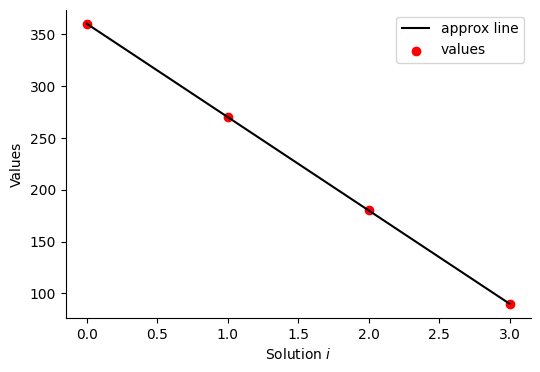

In [139]:
plotValues(iterValues)